In [1]:
%load_ext autoreload
%autoreload 2

# file ops
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

# spatial
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray

# machine learning
from dask.distributed import get_client, Client, LocalCluster, SSHCluster
from concurrent.futures import ThreadPoolExecutor

# cluster = LocalCluster(n_workers=4)
# client = Client(cluster)
# client.close()
# cluster.close()

# custom
from coralshift.utils import file_ops, config, utils
from coralshift.dataloading import get_data
from coralshift.plotting import spatial_plots, visualise_results
from coralshift.machine_learning import static_models, run_model, ml_results
from coralshift.processing import ml_processing
from coralshift.processing import spatial_data


import cmipper


# data fps
gt_data_dir = config.gt_data_dir
config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
time.time()

1717766219.9729402

In [11]:
config_info = file_ops.read_yaml(config_fp)
static_models.run_models([
    # "lin_reg",
    # "log_reg",
    # "max_ent",
    # "rf_cf",
    # "gb_cf",
    "rf_reg",
    # "gb_reg",
    # "xgb_cf",
    "xgb_reg",
    # # "mlp_cf",
    # "mlp_reg",
], config_fp=config_fp)

['python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code rf_reg --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps-priv/maps/rt582/coralshift/logs/runs/0-1d/rf_reg/ID016_cmip6_unep_gebco_slope.log 2>&1 &', 'python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code xgb_reg --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps-priv/maps/rt582/coralshift/logs/runs/0-1d/xgb_reg/ID013_cmip6_unep_gebco_slope.log 2>&1 &']


In [15]:
# machine learning
from dask.distributed import get_client, Client, LocalCluster
from concurrent.futures import ThreadPoolExecutor

cluster = LocalCluster(n_workers=4)
client = Client(cluster)
# client.close()
# cluster.close()

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35489 instead
  warnings.warn(


In [6]:
cluster = SSHCluster("sherwood.cl.cam.ac.uk")

2024-06-05 14:03:13,005 - distributed.deploy.spec - WARNING - Cluster closed without starting up


RuntimeError: Cluster failed to start: [Errno -3] Temporary failure in name resolution

In [16]:
client.status

'running'

In [12]:
client

<Client: 'tcp://127.0.0.1:36411' processes=4 threads=256, memory=0.98 TiB>

In [7]:
type(client)

distributed.client.Client

In [10]:
# client.close()
client.shutdown()
client

<Client: No scheduler connected>

# Dividing data into buffered file chunks
This is useful for reprojecting functionality which just won't work at high resolutions on a global scale. The individual files can be be recast into a single netcdf using `open_mfdataset` if required in future (i.e. through `partial_fit` training), or can be used as individual files for use with e.g. Apache Sedona. 

Just going to byte (ha) the bullet and code it up.

In [ ]:
# file_ops.rename_nc_with_coords("/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023.nc")

In [ ]:
# fps = list(Path("/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded/cropped_N0_S-32_W130_E170/hfds").glob("*.nc"))[:-1]
fps = list(Path("/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded/hfds").glob("*.nc"))[:-1]
xa.open_mfdataset(fps)
# len(list(fps))

In [ ]:
from cmipper import parallelised_download_and_process

parallelised_download_and_process.concat_cmip_files_by_time("EC-Earth3P-HR", [1950, 2015], "r1i1p2f1", fp_dir = "/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1", download_config_dict=config_info)

In [ ]:
parallelised_download_and_process.merge_cmip_data_by_variables("EC-Earth3P-HR", [1950, 2015], "r1i1p2f1", fp_dir="/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded", download_config_dict=config_info)

In [ ]:
def generate_chunk_bounds(degrees_lat, degrees_lon, lat_range=(-90, 90), lon_range=(-180, 180), lat_buffer=1, lon_buffer=1):
    """
    Generate latitude and longitude bounds for chunks spanning a specified range.

    Parameters:
    - degrees_lat (float): Number of degrees on each side of latitude chunks.
    - degrees_lon (float): Number of degrees on each side of longitude chunks.
    - lat_range (tuple): Range of latitudes (default: (-90, 90)).
    - lon_range (tuple): Range of longitudes (default: (-180, 180)).

    Returns:
    - lat_bounds (list): List of latitude bounds for each chunk.
    - lon_bounds (list): List of longitude bounds for each chunk.
    """

    # Calculate the number of latitude and longitude chunks
    N_lat = int((lat_range[1] - lat_range[0]) / degrees_lat)
    N_lon = int((lon_range[1] - lon_range[0]) / degrees_lon)

    # Calculate the step size for latitude and longitude
    lat_step = (lat_range[1] - lat_range[0]) / N_lat
    lon_step = (lon_range[1] - lon_range[0]) / N_lon

    # Generate latitude bounds
    lat_bounds = [(lat_range[0] + i * lat_step, lat_range[0] + (i + 1) * lat_step) for i in range(N_lat)]

    # Generate longitude bounds
    lon_bounds = [(lon_range[0] + i * lon_step, lon_range[0] + (i + 1) * lon_step) for i in range(N_lon)]

    lat_bounds = [lat_bounds[0]-buffer if buffer else lat_bounds[0] for buffer in [lat_buffer, 0]]
    
    return lat_bounds, lon_bounds

# Example usage:
degrees_lat = 10
degrees_lon = 10
lat_bounds, lon_bounds = generate_chunk_bounds(degrees_lat, degrees_lon)
print("Latitude bounds:", lat_bounds)
print("Longitude bounds:", lon_bounds)


In [2]:
unep_xa = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="unep")

Loading UNEP_GDCR xarray at 0.004 degrees resolution.


In [12]:
unep_001 = get_data.ReturnRaster(resolution=0.01, config_info=config_info).return_raster(dataset="unep")["UNEP_GDCR"]
unep_01 = get_data.ReturnRaster(resolution=0.1, config_info=config_info).return_raster(dataset="unep")["UNEP_GDCR"]
unep_1 = get_data.ReturnRaster(resolution=1, config_info=config_info).return_raster(dataset="unep")["UNEP_GDCR"]

Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


	resampling dataset to 1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'og UNEP'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fc718f4cad0>)

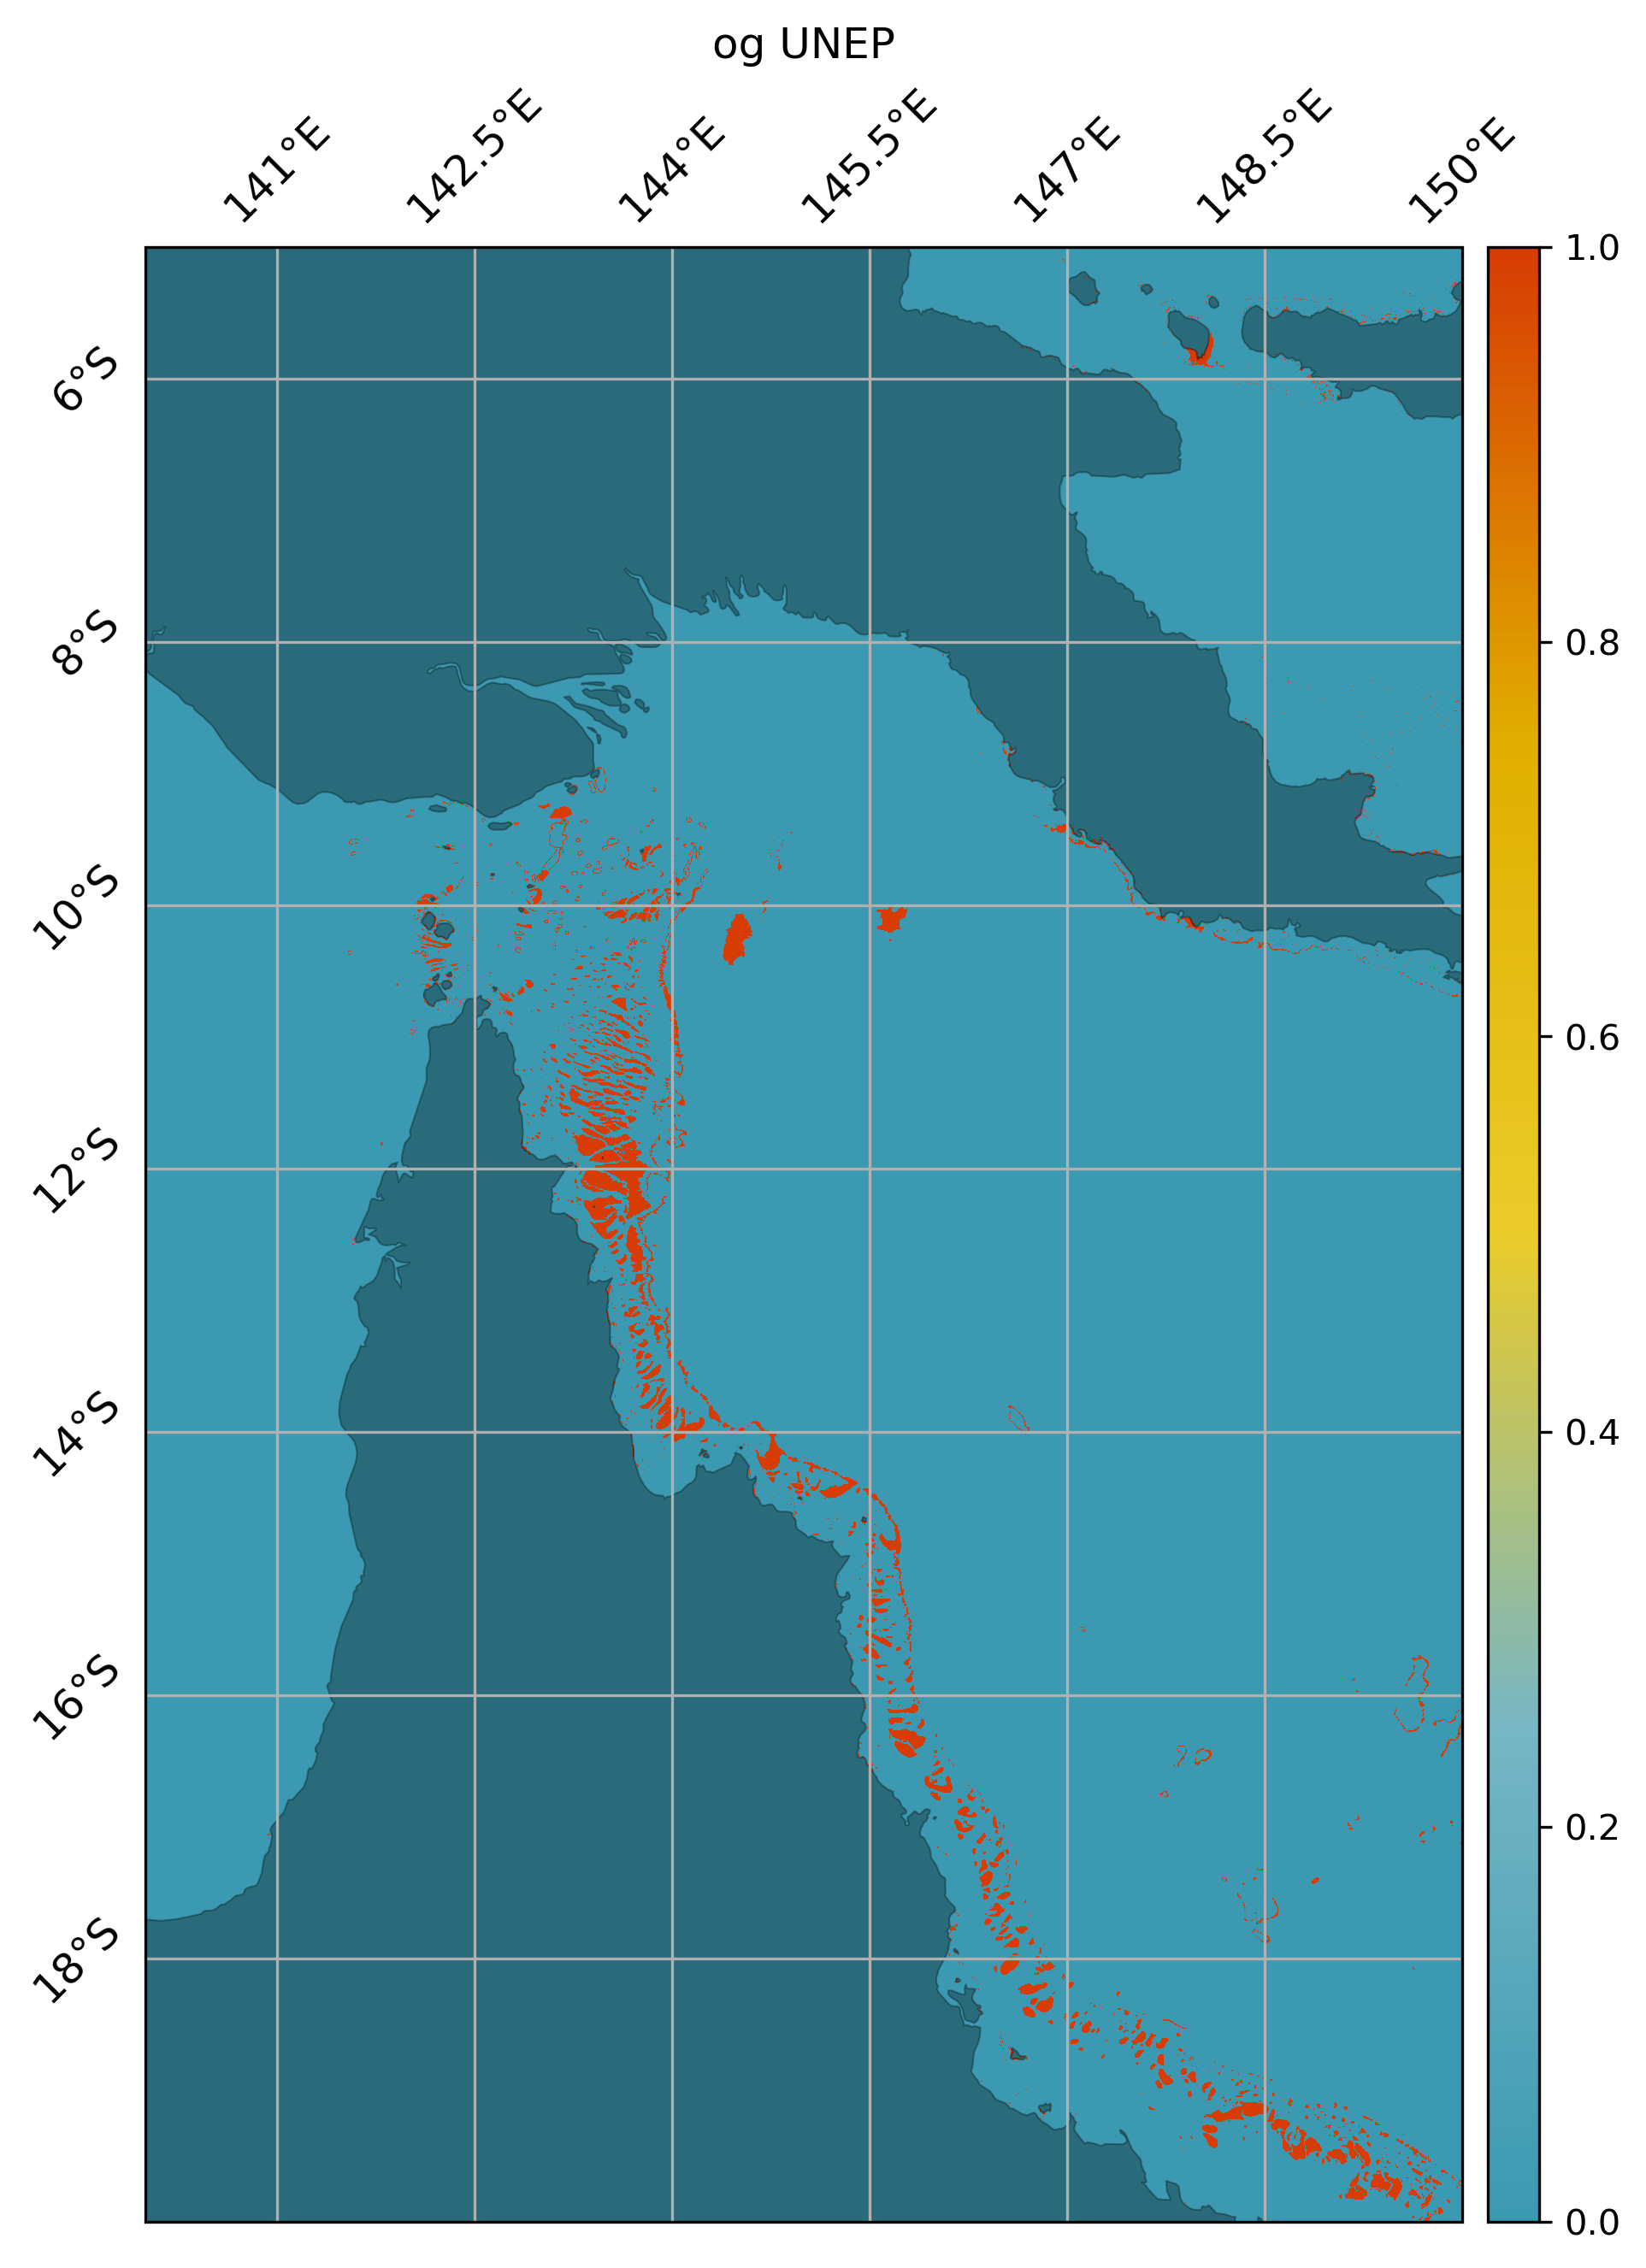

In [11]:
spatial_plots.plot_spatial(unep_xa["UNEP_GDCR"].sel(latitude=slice(*lats), longitude=slice(*lons)), title="og UNEP")

(<Figure size 1500x500 with 6 Axes>,
 <GeoAxes: title={'center': 'UNEP 1'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fc71a024410>)

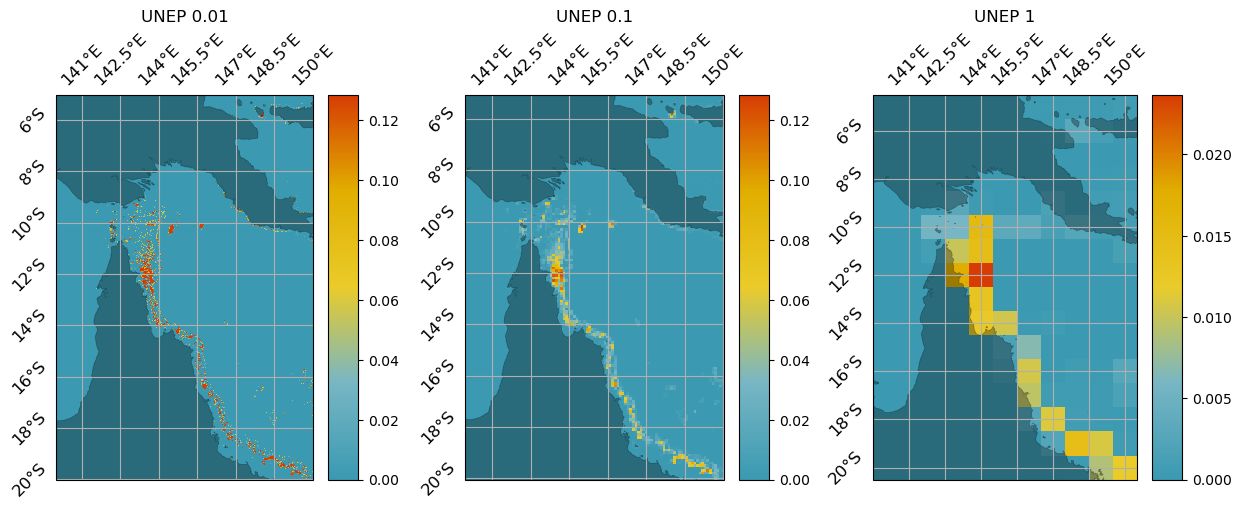

In [17]:
lats = [-20, -5]
lons = [135, 150]
import cartopy.crs as ccrs
f, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(unep_001.sel(latitude=slice(*lats), longitude=slice(*lons)), title="UNEP 0.01", fax=(f, ax[0]))
spatial_plots.plot_spatial(unep_01.sel(latitude=slice(*lats), longitude=slice(*lons)), title="UNEP 0.1", fax=(f, ax[1]))
spatial_plots.plot_spatial(unep_1.sel(latitude=slice(*lats), longitude=slice(*lons)), title="UNEP 1", fax=(f, ax[2]))

Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


(array([1.529300e+04, 2.844000e+03, 2.836000e+03, 3.154000e+03,
        3.741000e+03, 4.878000e+03, 5.615000e+03, 7.324000e+03,
        1.148000e+04, 5.547636e+06]),
 array([-0.12851693, -0.11566524, -0.10281354, -0.08996185, -0.07711016,
        -0.06425846, -0.05140677, -0.03855508, -0.02570339, -0.01285169,
        -0.        ]),
 <BarContainer object of 10 artists>)

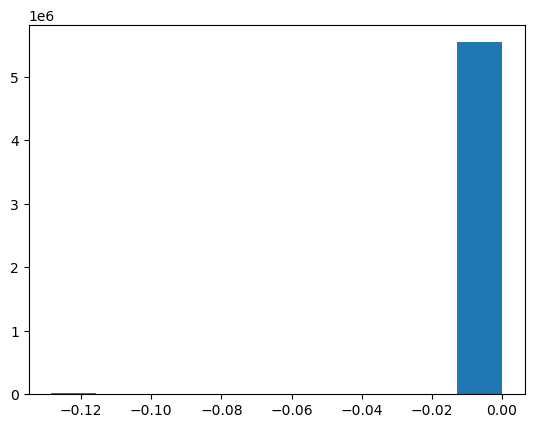

In [7]:
plt.hist(get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")["UNEP_GDCR"].values.flatten())

In [11]:
print("min:", np.min(unep_xa["UNEP_GDCR"].values))
print("max:", np.max(unep_xa["UNEP_GDCR"].values))

min: 0
max: 4


In [10]:
lat_res, lon_res = unep_xa.rio.resolution()[0], unep_xa.rio.resolution()[1]
cell_area = lat_res * lon_res   # in degrees
cell_area = cell_area * 110e3 * 110e3   # in m2 # TODO: adjust further from the equator
area_raster = 30**2 * unep_xa / cell_area

print("min:", np.min(area_raster["UNEP_GDCR"].values))
print("max:", np.max(area_raster["UNEP_GDCR"].values))

min: 0.0
max: 0.017135590453279455


# Running models

In [14]:
def calc_worker_memory_lim(n_workers, memory_limit):
    return memory_limit / n_workers

def memory_string(memory_limit):
    return str(memory_limit) + "GB"
     
memory_limit = memory_string(calc_worker_memory_lim(4, 16))
cluster = LocalCluster(n_workers=4, memory_limit=memory_limit)
client = Client(cluster)

client

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40397 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:39735' processes=4 threads=256, memory=14.90 GiB>

In [12]:
client

<Client: 'tcp://127.0.0.1:38869' processes=4 threads=256, memory=1.86 GiB>

In [5]:
# config.gdcr_dir
config.wri_dir

PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/wri')

In [13]:
Path(config.gt_data_dir) / f"{"UNEP_GDCR".upper()}/rasters"

PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters')

In [24]:
unep_xa = get_data.ReturnRaster(lats=[-90,90],lons=[-180,180], config_info=config_info).get_raw_raster(dataset="unep")
unep_xa

# /maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters


ID UNEP_GDCR
FP /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp
XA_DIR /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters
POTENTIAL_FPS [PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc'), PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S5-1_N0-1_E139-9_E145-1.nc')]
CORRECT_RESOLUTIONS [PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc'), PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S5-1_N0-1_E139-9_E145-1.nc')]
XAS [PosixPath('/maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc')]
Loading UNEP_GDCR xarray at 0.004 degrees resolution.


<xarray.Dataset> Size: 11GB
Dimensions:    (latitude: 16035, longitude: 86399)
Coordinates:
  * latitude   (latitude) float64 128kB -34.3 -34.29 -34.29 ... 32.51 32.51
  * longitude  (longitude) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    UNEP_GDCR  (latitude, longitude) float64 11GB ...

In [27]:
wri_xa = get_data.ReturnRaster(lats=[-90,90],lons=[-180,180], config_info=config_info).get_raw_raster(dataset="wri")
wri_xa

Loading WRI_REEF_EXTENT data...


/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/dask/dataframe/core.py:7175: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


generating UNEP raster at 0.004 degrees resolution...


ValueError: cannot convert float NaN to integer

['python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code lin_reg --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps-priv/maps/rt582/coralshift/logs/runs/0-01d/lin_reg/ID000_cmip6_unep_gebco_slope.log 2>&1 &', 'python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code gb_cf --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps-priv/maps/rt582/coralshift/logs/runs/0-01d/gb_cf/ID001_cmip6_unep_gebco_slope.log 2>&1 &', 'python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code rf_reg --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps-priv/maps/rt582/coralshift/logs/runs/0-01d/rf_reg/ID017_cmip6_unep_gebco_slope.log 2>&1 &', 'python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code gb_reg --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps

# Investigating distributions of unep at different resolutions

In [ ]:
gebco_xa = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="gebco")

In [ ]:
config_info["datasets"] = ["unep", "gebco"]
config_info["resolution"] = 0.5
# config_info["resolution"]

In [ ]:
config_info["datasets"] = ["unep", "gebco"]
resolutions = [1, 0.75, 0.5, 0.25, 0.1, 0.01, gebco_xa.rio.resolution()[0]]
arrays = {}

for res in tqdm(resolutions, total=len(resolutions)):
    config_info["resolution"] = res
    array = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()
    arrays[res] = array

In [ ]:
arrs = [arrays[res]["UNEP_GDCR"] for res in resolutions]
spatial_plots.plot_comparative_histograms_visuals(
    arrs, resolutions, val_lims=None, 
    cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})

In [ ]:
from cmipper import file_ops as cmipper_file_ops

masked_arrays = {}
for arr_i, (arr_res, arr) in tqdm(enumerate(arrays.items()), total=len(arrays)):
    res = resolutions[arr_i]



    X, y = ml_processing.ds_to_ml_ready(arr)
    # print(X["elevation"])
    X_xa = spatial_data.spatially_reform_data(X["elevation"])
    y_xa = spatial_data.spatially_reform_data(y)

    masked_arrays[res] = xa.merge([X_xa, y_xa])

In [ ]:
[*config_info["lats"], *config_info["lons"]]

In [ ]:
np.nansum(masked_arrays[resolutions[-1]]["elevation"].values)

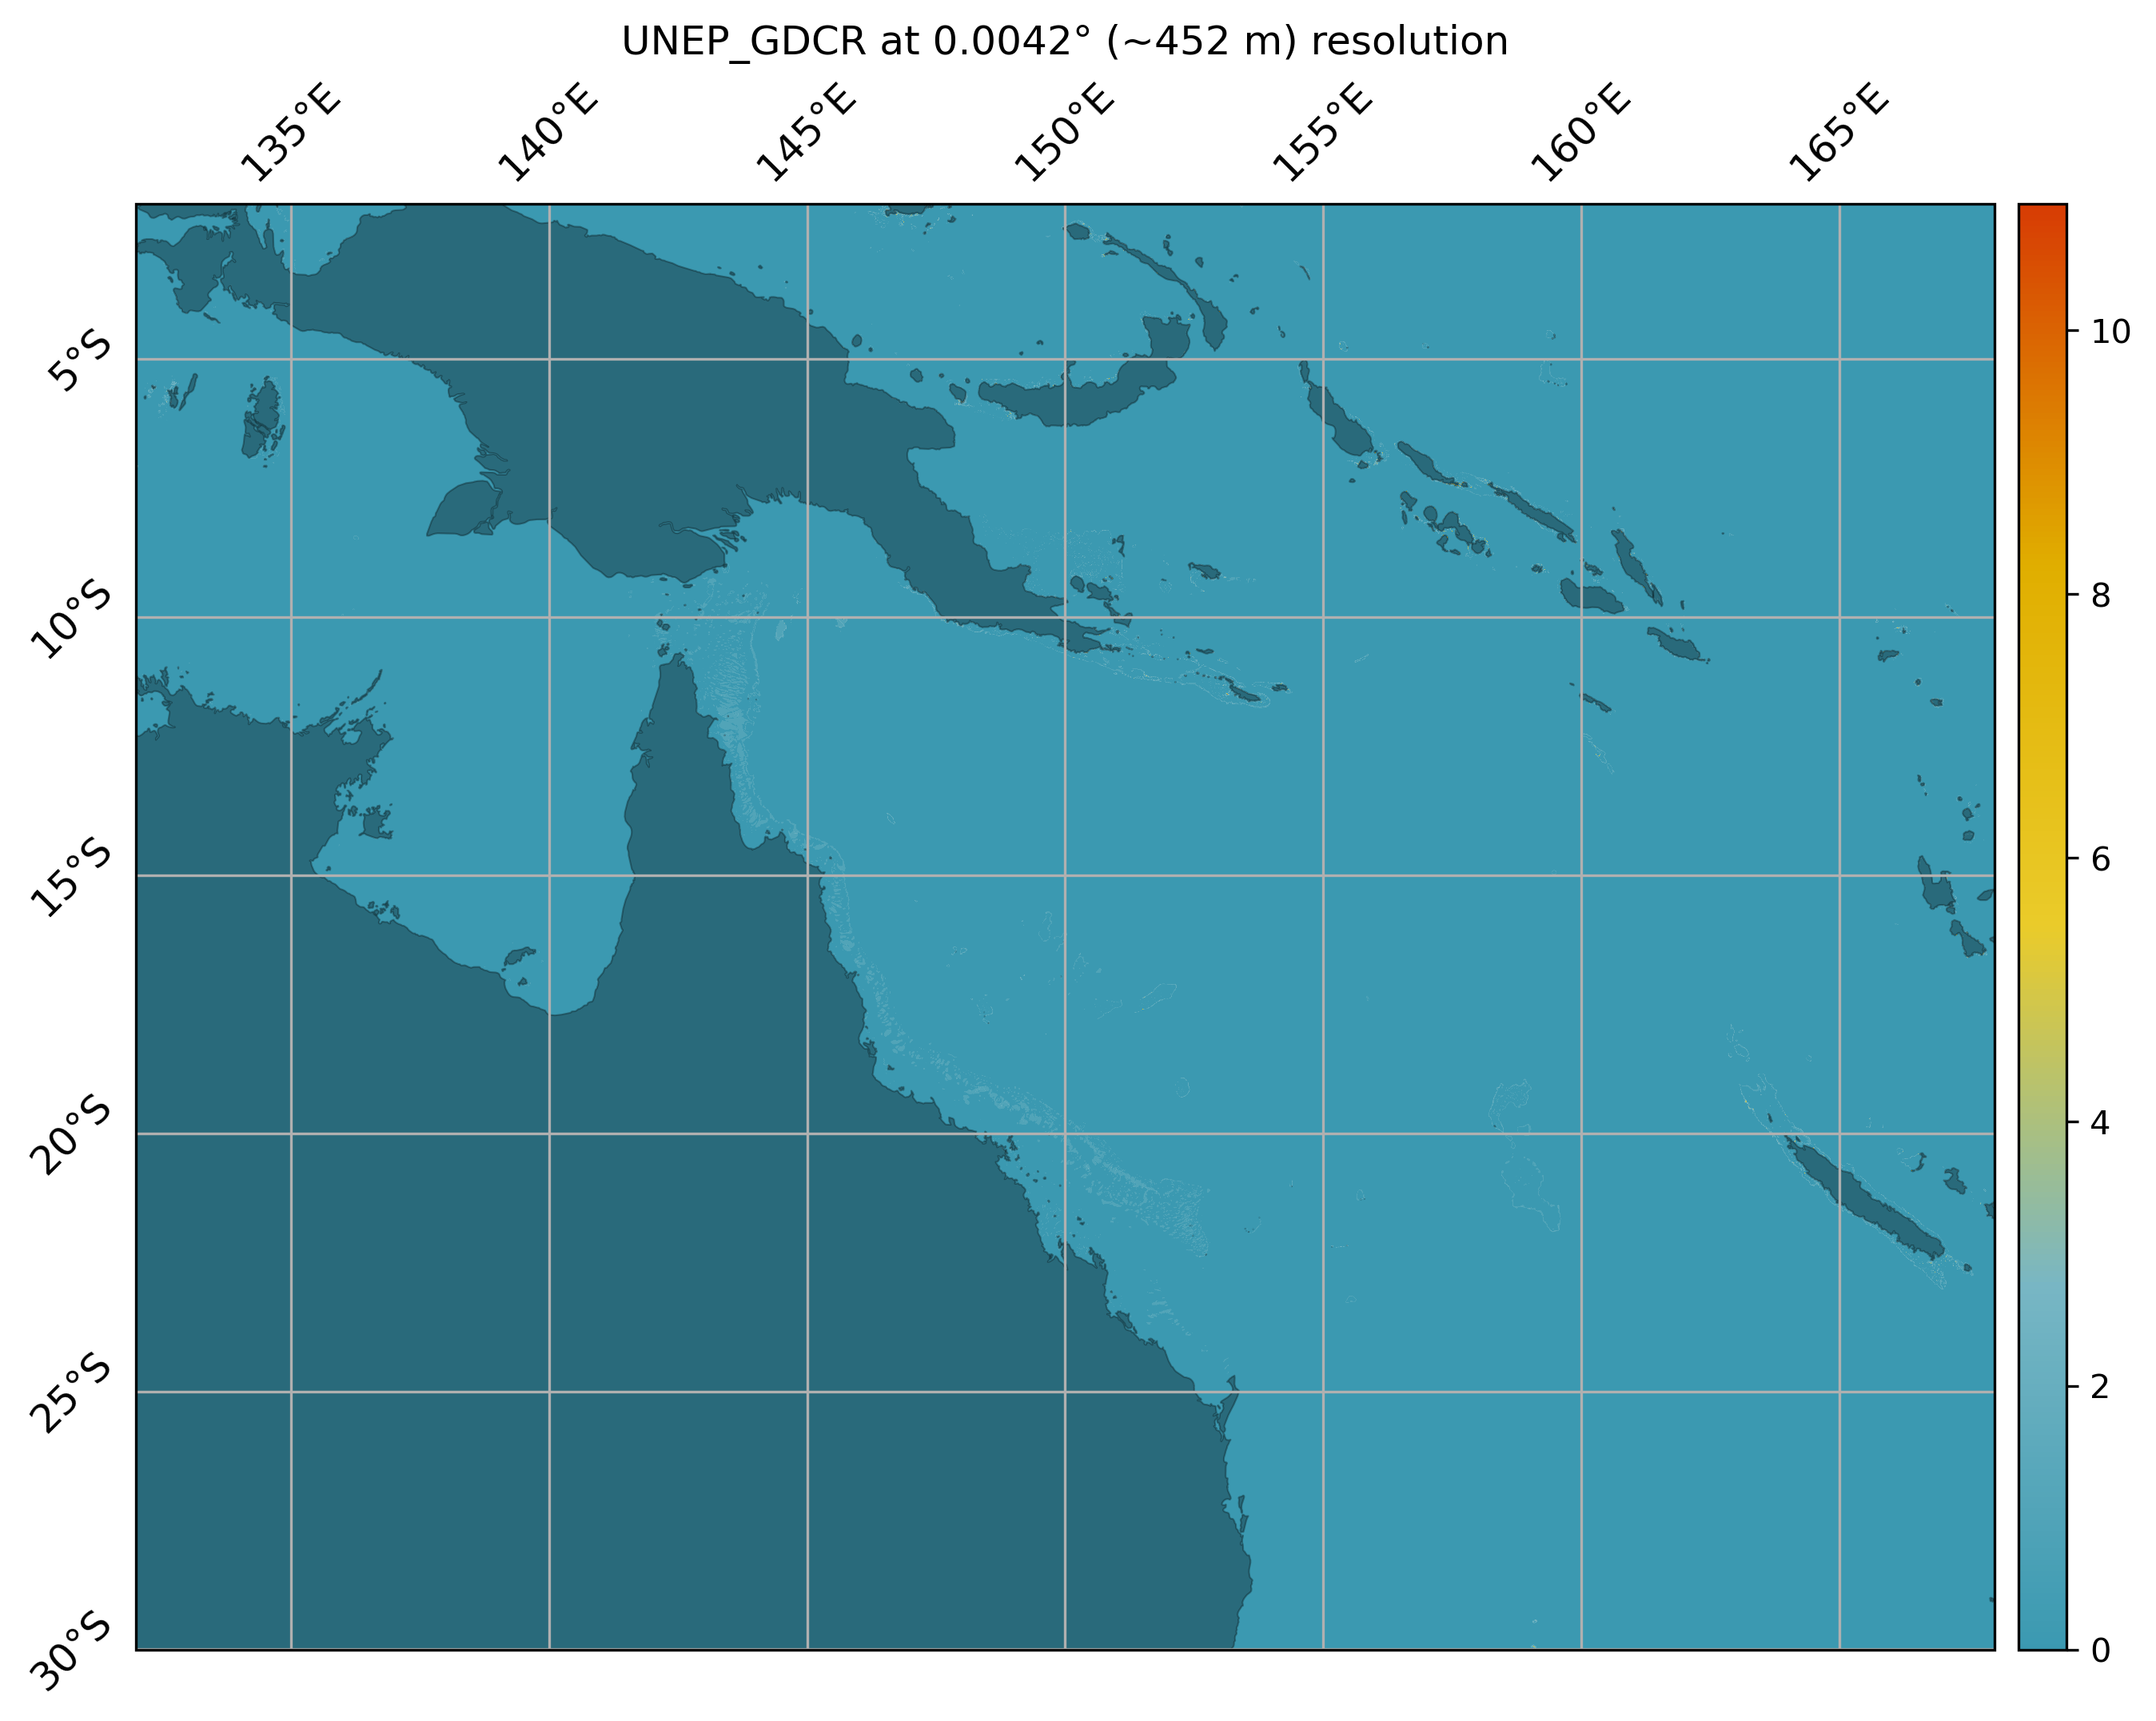
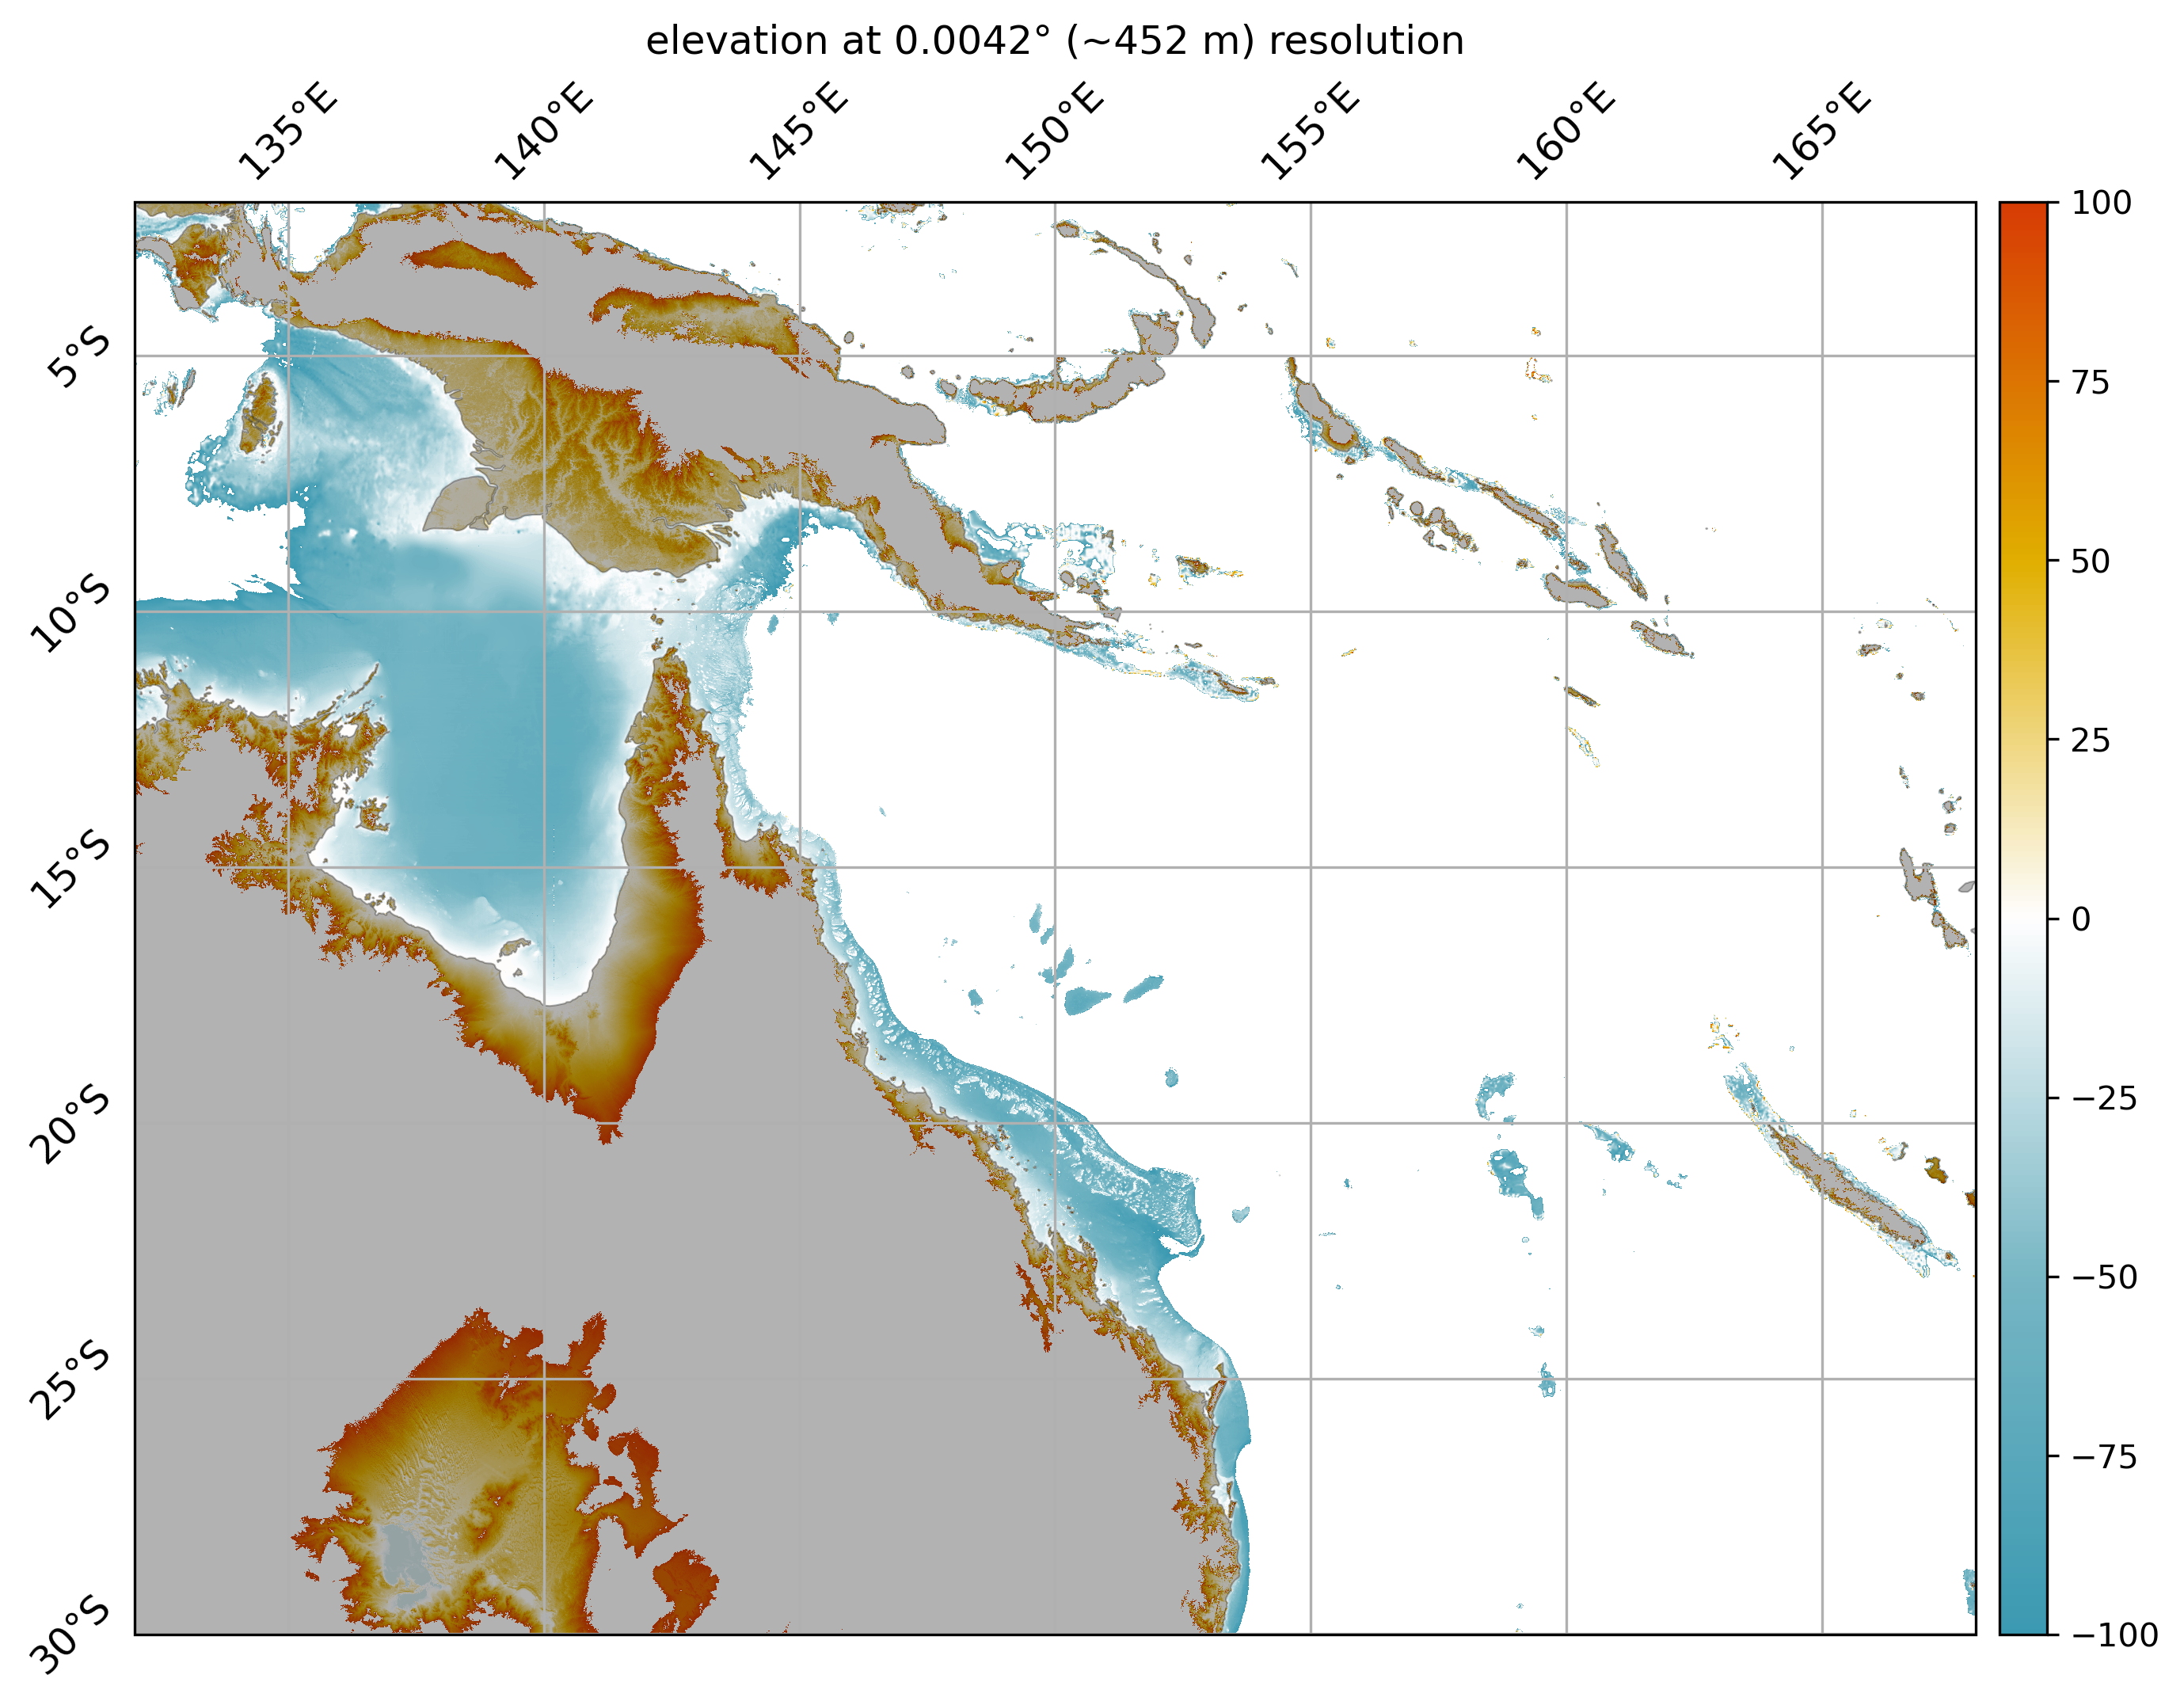
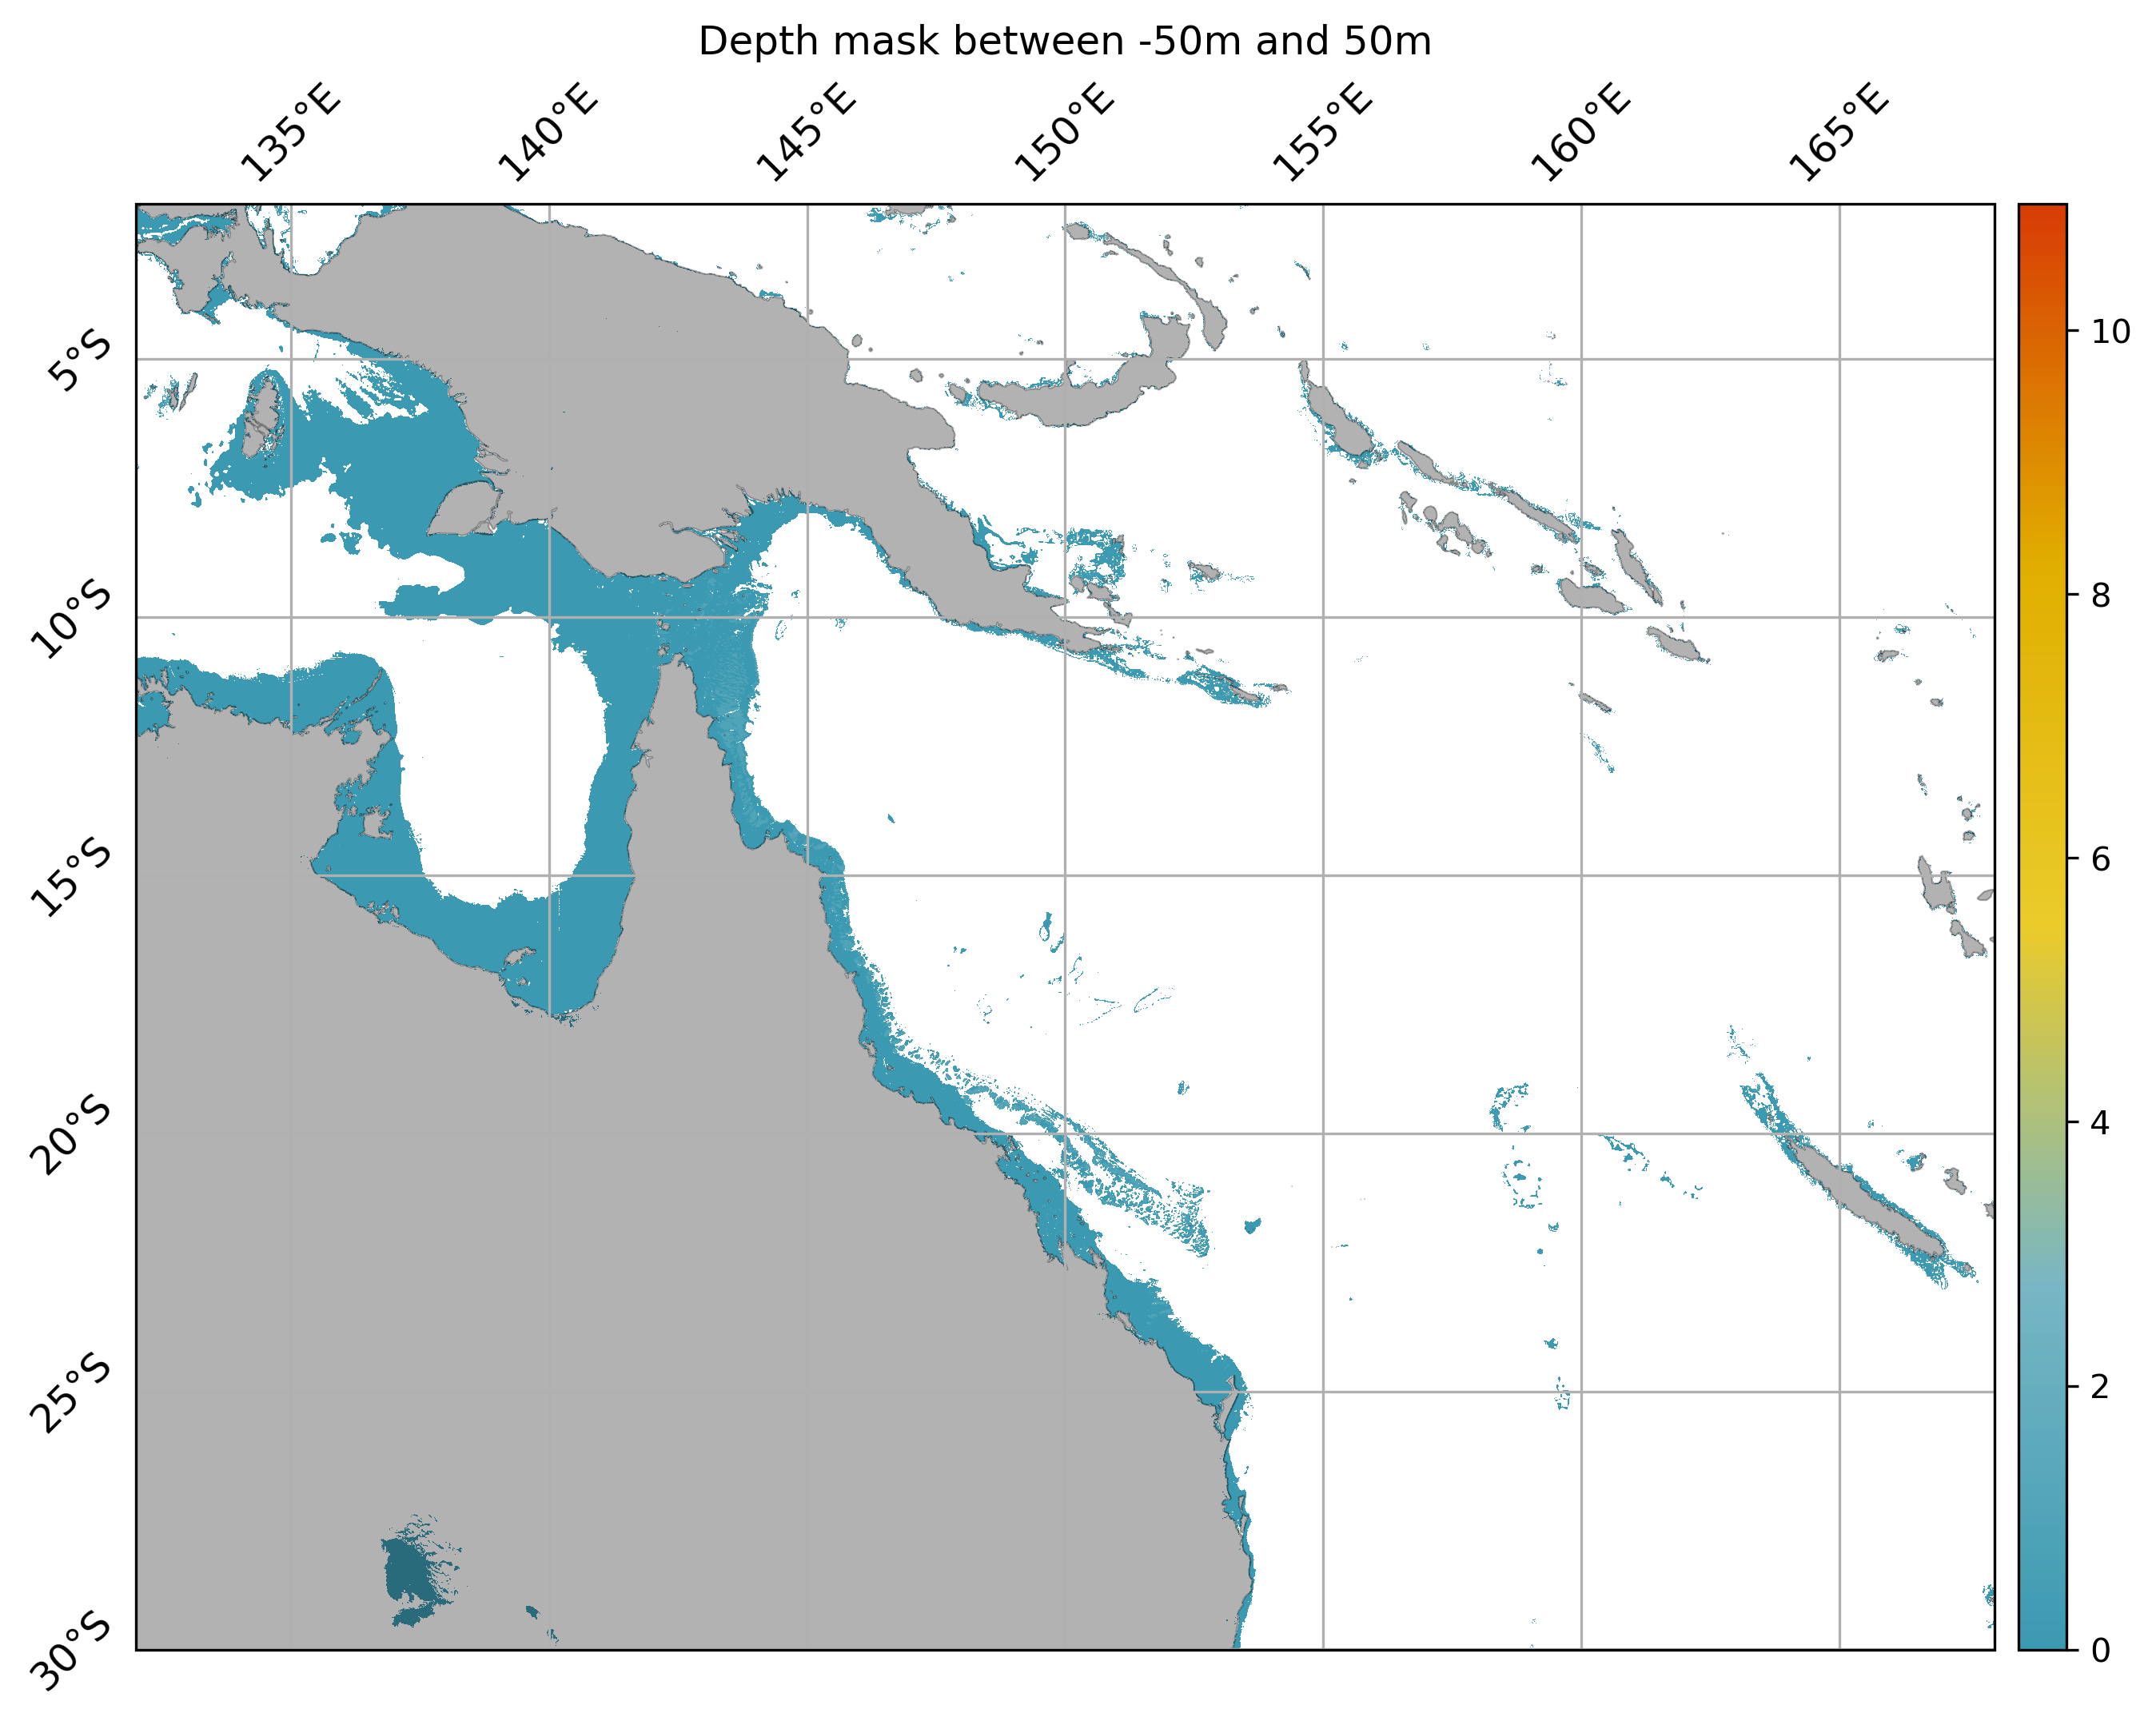

In [ ]:
# count the number of cells between 0 and -50
spatial_plots.plot_spatial(xa.where(
    (gebco_xa["elevation"] >= -100) & (gebco_xa["elevation"] <= 100),
    gebco_xa["elevation"],
    np.nan
), cbar_dict={"cmap_type": "div"})

In [ ]:
arrays[0.004166666666666676]

In [ ]:
masked = xa.where(
    (arrays[0.004166666666666676]["elevation"] >= -50) & (arrays[0.004166666666666676]["elevation"] <= 0),
    # arrays[0.004166666666666676]["elevation"],
    arrays[0.004166666666666676]["UNEP_GDCR"],
    np.nan
)
spatial_plots.plot_spatial(masked, cbar_dict={"cmap_type": "seq"}, title="Depth mask between -50m and 50m")

In [ ]:
np.nansum(masked.values)

In [ ]:
spatial_plots.plot_spatial(arrs_no_mask[-1])

## effect of masking
Good maintenance of coral, only somewhat cut off: but balances classes somewhat.

Should I just be setting the depth mask at a single value? I don't think it's worth doing the whole ocean colour thing since this is rubbish. And misses potential changes e.g. due to currents.

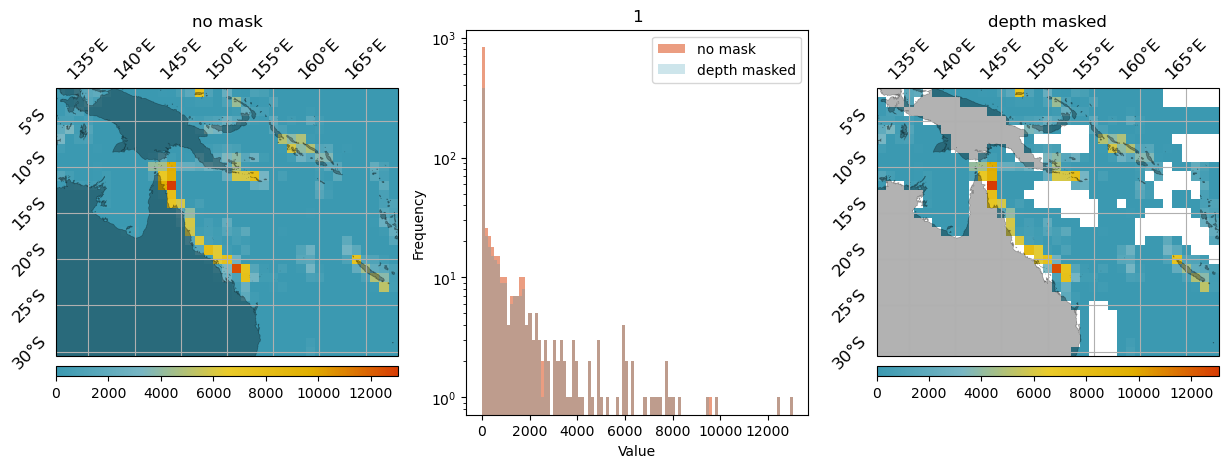
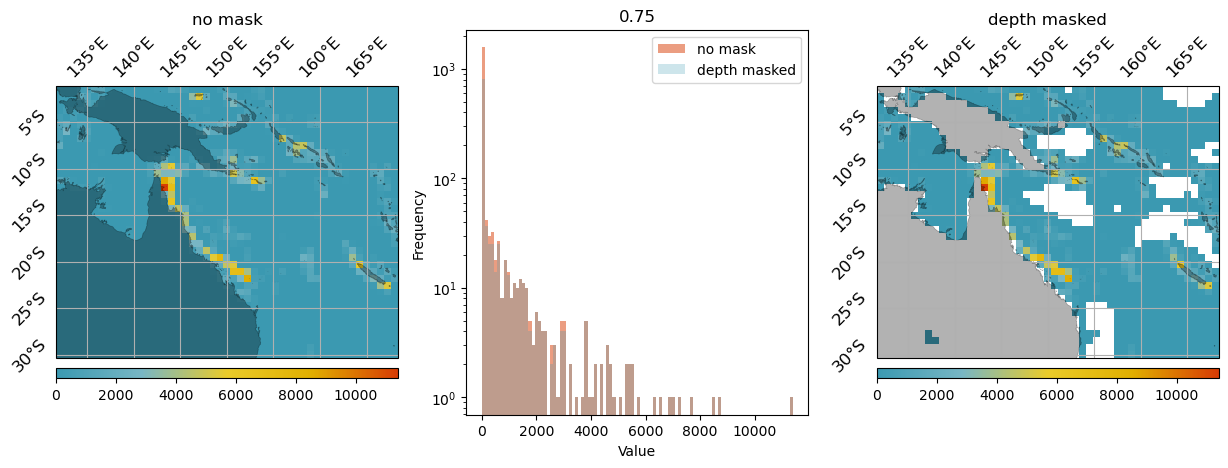
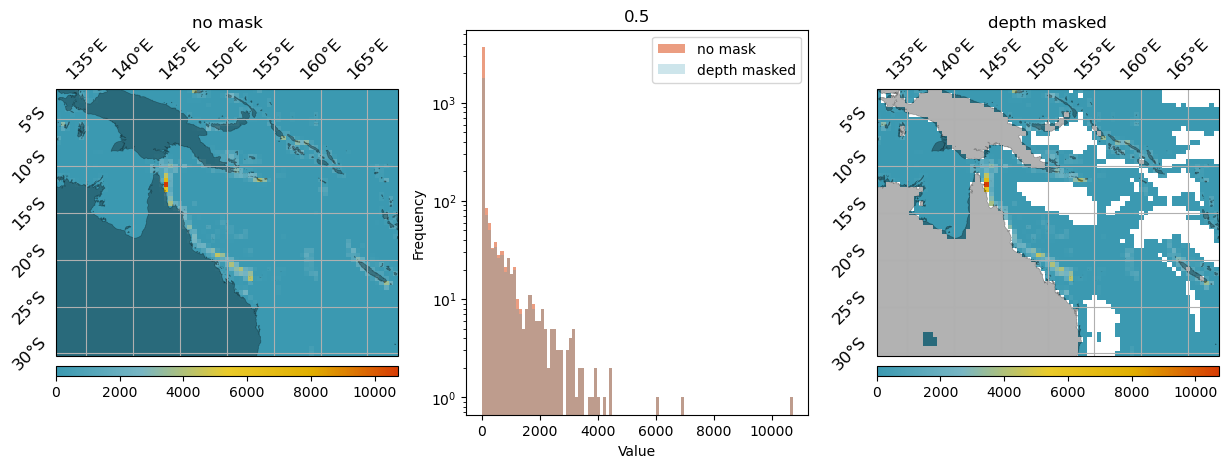
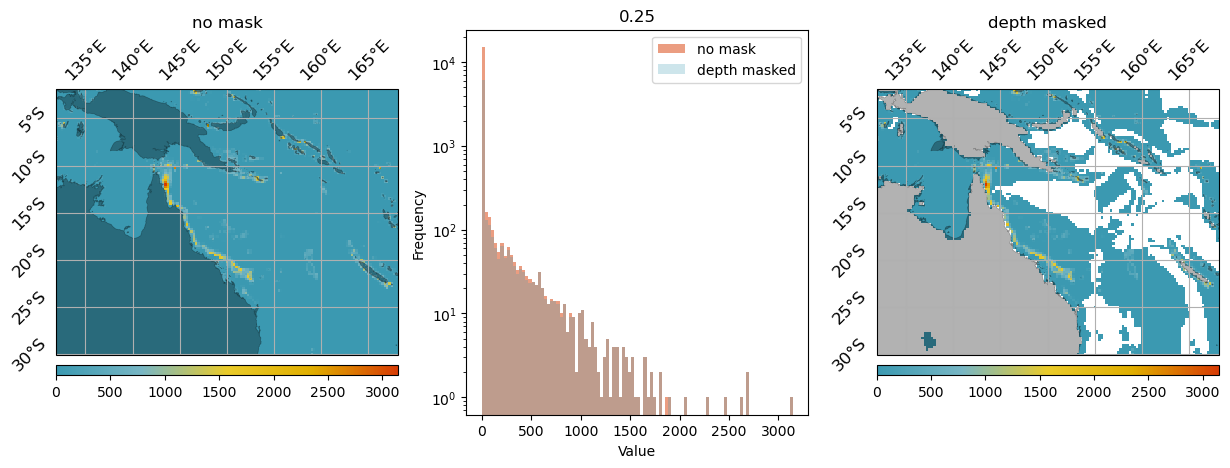
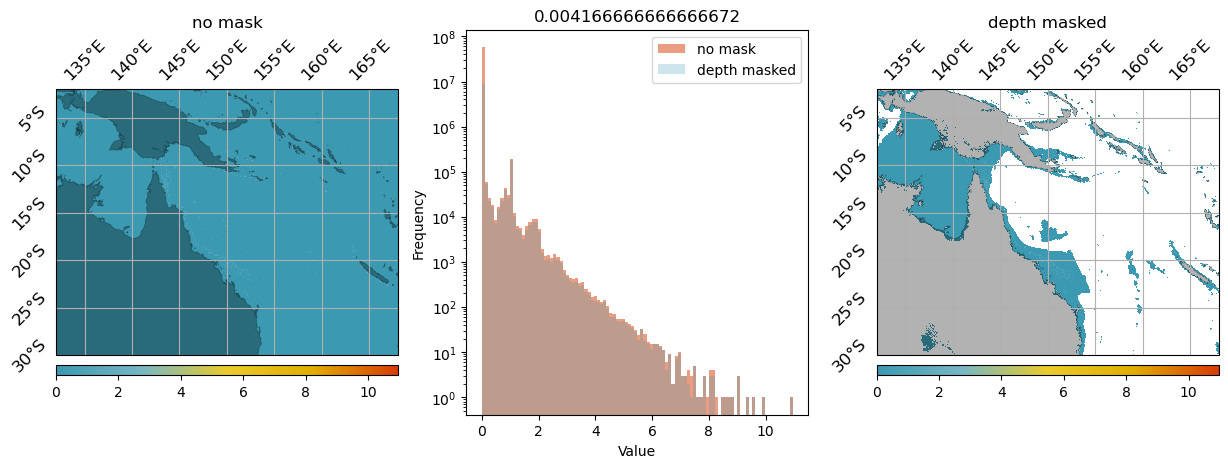

In [ ]:
arrs_no_mask = [arrays[res]["UNEP_GDCR"] for res in resolutions]
arrs_masked = [masked_arrays[res]["UNEP_GDCR"] for res in resolutions]

spatial_plots.plot_two_methods_comparative_histograms_visuals(
    arrs_no_mask, arrs_masked, resolutions, "no mask", "depth masked", val_lims=None,
    cbar_dict={"cmap_type": "seq", "orientation": "horizontal"}, 
    # map_extents = [*config_info["lats"], *config_info["lons"]]
    map_extents = None
    )

In [ ]:
arrs_no_mask[-1]

In [ ]:
print("unmasked sum:", np.nansum(arrs_no_mask[-1].values))
print("masked sum:", np.nansum(arrs_masked[-1].values))

In [ ]:
arrays.keys()

In [ ]:
# unep
unep_gebco = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()
# bathymetry

In [ ]:
resolutions = [1, 0.75, 0.5, 0.25, 0.1, 0.01, lim_bathymetry_xa.rio.resolution()[0]]
arrays = {}

for res in tqdm(resolutions, total=len(resolutions)):
    array = resampling.rio_absolute_resample(
        unep_xa_cs,
        res,
        res,
        lat_range = CASE_STUDY_LATS,
        lon_range = CASE_STUDY_LONS,
        resample_method = Resampling.sum,
    )
    arrays[res] = array

## Getting data

In [ ]:
config_info = file_ops.read_yaml(config_fp)
out = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")
out

In [ ]:
import cartopy.crs as ccrs
LONS = [140,145]
LATS = [-15,-10]

f, ax = plt.subplots(ncols=3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[20,5])
spatial_plots.plot_spatial(out["tos"].isel(time=0).sel(latitude=slice(*LATS), longitude=slice(*LONS)), fax=(f,ax[0]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})
spatial_plots.plot_spatial(get_data.apply_fill_loess(out, 3,3)["tos"].isel(time=0).sel(latitude=slice(*LATS), longitude=slice(*LONS)), fax=(f,ax[1]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})
spatial_plots.plot_spatial(get_data.apply_fill_loess(out, 10,10)["tos"].isel(time=0).sel(latitude=slice(*LATS), longitude=slice(*LONS)), fax=(f,ax[2]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})

In [ ]:
unep_focus = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="unep").sel(latitude=slice(*config_info["lats"]), longitude=slice(*config_info["lons"]))

In [ ]:
out["UNEP_GDCR"].plot()

In [ ]:
print(np.sum(out["UNEP_GDCR"].values))
print(np.sum(unep_focus["UNEP_GDCR"].values))

In [ ]:
config_info["datasets"]

In [ ]:
cmip6_data_dir = "/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded"
len(list(Path(cmip6_data_dir).rglob("*.nc")))


In [ ]:
unep = xa.open_dataset("/maps/rt582/coralshift/data/ground_truth/unep_wcmc/rasters/unep_0-004_n32-5_s34-3_w180-0_e180-0.nc")
unep

In [ ]:
# unep.to_netcdf("unep_0-004.nc")
file_ops.rename_nc_with_coords("/maps/rt582/coralshift/data/ground_truth/unep_wcmc/rasters/unep_0-004.nc")

In [ ]:
# /maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded
(trains, tests, vals), info = ml_processing.ProcessMLData(
    config_info=config_info
).generate_ml_ready_data()
# dss

In [ ]:
dtrains, dtests, dvals = static_models.RunStaticML(model_code="xgb_reg", trains=trains, tests=tests, vals=vals).xgboost_formatting(trains=trains, tests=tests, vals=vals)

In [ ]:
tr, te, va = static_models.RunStaticML("xgb_reg", trains, tests, vals, config_info=config_info).run_model()

In [ ]:
static_models.RunStaticML(
    model_code="xgb_reg", trains=tr, tests=te, vals=va, config_info=config_info).run_model()

In [ ]:
tr[0]

In [ ]:
dtr

In [ ]:
elevation = xa.open_dataset("/maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc").sel(lat=slice(-5,-4), lon=slice(130, 131)).drop_vars("crs").astype(np.float32)
elevation

In [ ]:
utils.mask_above_threshold(elevation, 10)

In [ ]:
xa_d = xa.open_dataset("/maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc")["elevation"]

# xa.open_dataset("/maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc")["elevation"].map(lambda x: x.where(x <= 100, np.nan))
xa_d.where(xa_d <= 100, np.nan)

In [ ]:
ml_processing.ProcessMLData(config_info=config_info).scale_data(trains, tests, vals)

In [ ]:
y_scaler

In [ ]:
y_scaler.transform(pd.Series(y_scaled[0]))

In [ ]:
type(trains[1])

In [ ]:
y_scaler

In [ ]:
dss

In [ ]:
import cartopy.crs as ccrs
f, ax = plt.subplots(ncols=3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[20,5])
spatial_plots.plot_spatial(dss["tos_january_mean"], fax=(f,ax[0]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})
spatial_plots.plot_spatial(dss["elevation"], fax=(f,ax[1]), cbar_dict={"cmap_type": "div", "orientation": "horizontal"}, val_lims=[-200,100])
spatial_plots.plot_spatial(dss["UNEP_GDCR"], fax=(f,ax[2]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})

In [ ]:
import cartopy.crs as ccrs
f, ax = plt.subplots(ncols=3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[20,5])
spatial_plots.plot_spatial(dss["tos"].isel(time=0), fax=(f,ax[0]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})
spatial_plots.plot_spatial(dss["elevation"], fax=(f,ax[1]), cbar_dict={"cmap_type": "div", "orientation": "horizontal"}, val_lims=[-200,100])
spatial_plots.plot_spatial(dss["UNEP_GDCR"], fax=(f,ax[2]), cbar_dict={"cmap_type": "seq", "orientation": "horizontal"})

In [ ]:
cmip_raster = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()

## Elapid splitting

In [ ]:
tr, te, va = ml_processing.ProcessMLData(config_info=config_info).split_dataset(cmip_raster)

In [ ]:
df = tr[1]
# latitudes, longitudes = spatial_data.spatially_reform_data(df, resolution=1)
new_out = spatial_data.spatially_reform_data(df, resolution=1)
new_out.plot()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

f, (tr_ax, te_ax) = plt.subplots(1, 2, figsize=(12,7), subplot_kw={'projection': ccrs.PlateCarree()})

tr_xa = spatial_data.spatially_reform_data(tr[1], resolution=1)
te_xa = spatial_data.spatially_reform_data(te[1], resolution=1)

# get min and max of both xarray dataarrays
vmin = min(tr_xa.min(), te_xa.min())
vmax = max(tr_xa.max(), te_xa.max())

spatial_plots.plot_spatial(tr_xa, fax=(f,tr_ax), val_lims=[vmin, vmax], cbar_dict={"orientation":"horizontal"}, extent=[130, 170, -32, 0], title="train cells")
spatial_plots.plot_spatial(te_xa, fax=(f,te_ax), val_lims=[vmin, vmax], cbar_dict={"orientation":"horizontal"}, extent=[130, 170, -32, 0], title="test cells")

## XESMF Regridding

In [ ]:
import xesmf as xe


lon_range = config_info["lons"]
lat_range = config_info["lats"]
resolution = config_info["resolution"]

lon_range = sorted(lon_range)
lat_range = sorted(lat_range)
target_grid = xe.util.grid_2d(
    lon_range[0],
    lon_range[1],
    resolution,
    lat_range[0],
    lat_range[1],
    resolution,  # longitude range and resolution
)  # latitude range and resolution

# xa_d = cmip_raster.chunk({"latitude": 100, "longitude": 100})


In [ ]:
regridder = xe.Regridder(
    lim_raster.astype("float64", order="C"),
    target_grid.chunk({"y": 100, "x": 100, "y_b": 100, "x_b": 100}),
    method="bilinear",
    parallel=True,
)


In [ ]:
hr_df = regridded.to_dataframe()
hr_df.dropna(inplace=True)
lr_df = cmip_raster.to_dataframe()
lr_df.dropna(inplace=True)

f, (hr_a, lr_a) = plt.subplots(nrows=2, figsize=[14,5])

sns.boxplot(data=hr_df.iloc[::1000,:].drop(columns=["lon", "lat"]), ax=hr_a)
sns.boxplot(data=lr_df, ax=lr_a)
# lr_a.set_xlabel("Variables")

hr_a.xaxis.tick_top()
# rotate lr_a x axis labels by 90 degrees
hr_a.tick_params(axis="x", labelrotation=80)
lr_a.tick_params(axis="x", labelrotation=80)
# lr_a.set_xticks(lr_a.get_xticks(), lr_df.columns, rotation=90)

In [ ]:
# similarity of distributions statistical tests: e.g. wald test
# quantile-quantile plots
# Kolmogorov-Smirnov
# Chi-squared test

# model extremes – Mala 

In [ ]:
# calculate mean of dataframe
print(f"lr_df: mean={lr_df.mean().mean()} std={lr_df.std().std()}")
print(f"lr_df: mean={hr_df.mean().mean()} std={hr_df.std().std()}")


In [ ]:
lr_timeseries = get_data.ReturnRaster("cmip", config_info=config_info).get_raw_raster()
lr_timeseries

In [ ]:
import matplotlib.pyplot as plt

high_res_vals = regridded["mlotst_april_mean"].values.flatten()
high_res_vals = high_res_vals[~np.isnan(high_res_vals)]
low_res_vals = cmip_raster["mlotst_april_mean"].values.flatten()
low_res_vals = low_res_vals[~np.isnan(low_res_vals)]


f, ax = plt.subplots()

ax.boxplot(high_res_vals)
ax.boxplot(low_res_vals)

In [ ]:
# plot distribution of values, averaged across space
regridded.mean(dim=["y", "x"], skipna=True)

# regridded.mean()

In [ ]:
regridded.std(axis=None, skipna=True)

In [ ]:
regridded = regridder(cmip_raster.astype("float64", order="C"))

In [ ]:
regridded["mlotst_april_max"].plot()

In [ ]:
get_data.process_xesmf_regridded(regridder(lim_raster.astype("float64", order="C")))

In [ ]:
get_data.ReturnRaster("cmip", config_info=config_info).get_resampled_raster(cmip_raster["mlotst_april_max"].isel(latitude=slice(0,100), longitude=slice(0,100)))

## Running models

In [ ]:
config_info["resolution"]

In [ ]:
config_info

In [ ]:
file_ops.FileHandler(config_info=config_info, model_code="rf_reg").get_next_unique_fname().replace("_CONFIG", "")
    

In [ ]:
import yaml
import itertools
from pathlib import Path
from tempfile import NamedTemporaryFile
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def generate_model_run_command(model_code: str, config_fp: str | Path):
    config_info = file_ops.read_yaml(config_fp)
    logging_dir = file_ops.FileHandler(
        config_info=config_info, model_code=model_code, base_dir=config.run_logs_dir
    ).construct_fp_dir()
    logging_dir.mkdir(parents=True, exist_ok=True)
    log_name = (
        file_ops.FileHandler(config_info=config_info, model_code=model_code)
        .get_next_unique_fname()
        .replace("_CONFIG", "")
    )
    log_fp = f"{logging_dir}/{log_name}.log"

    command = [
        "python3",
        str(config.module_dir / "machine_learning/run_model.py"),
        "--model_code",
        f"{model_code}",
        "--config_fp",
        f"{str(config_fp)}",
    ]
    command.extend(
        [
            ">",
            log_fp,
            "2>&1",
            "&",
        ]
    )
    return " ".join(command)

def execute_subprocess_command(command):
    process = subprocess.Popen(command, shell=True)
    return process

def execute_subprocess_commands_in_parallel(commands):
    with ThreadPoolExecutor() as executor:
        executor.map(execute_subprocess_command, commands)


def wait_for_process_and_children(proc):
    proc.wait()  # Wait for the main process to complete
    # Get all child processes and wait for them to complete
    parent = psutil.Process(proc.pid)
    children = parent.children(recursive=True)
    for child in children:
        child.wait()

def execute_children_subprocess_command(command):
    process = subprocess.Popen(command, shell=True)
    wait_for_process_and_children(process)
    print("Children tasks completed, moving on to next command(s)")
    return process

def execute_subprocess_commands_in_parallel(commands, max_workers):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_command = {executor.submit(execute_children_subprocess_command, cmd): cmd for cmd in commands}
        for future in as_completed(future_to_command):
            command = future_to_command[future]
            try:
                future.result()
            except Exception as exc:
                print(f'{command} generated an exception: {exc}')
            else:
                print(f'{command} completed successfully')


def execute_subprocess_commands_in_parallel(commands):
    with ThreadPoolExecutor() as executor:
        executor.map(execute_subprocess_command, commands)

def execute_controlled_subprocess_command(command):
    process = subprocess.Popen(command, shell=True)
    process.wait()  # Wait for the process to complete
    return process

def execute_subprocess_commands_in_parallel_controlled(commands, max_workers):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_command = {executor.submit(execute_controlled_subprocess_command, cmd): cmd for cmd in commands}
        for future in as_completed(future_to_command):
            command = future_to_command[future]
            try:
                future.result()
            except Exception as exc:
                print(f'{command} generated an exception: {exc}')
            else:
                print(f'{command} completed successfully')

def generate_combinations(overrides):
    keys, values = zip(*overrides.items())
    return [dict(zip(keys, combination)) for combination in itertools.product(*values)]

def update_config_info(original_config, overrides):
    config_info = original_config.copy()
    config_info.update(overrides)
    return config_info

def run_models_with_configs(model_codes: list[str], config_fp: str | Path, configs: dict, num_commands_at_once: int=False):
    # Read the original config file
    original_config = file_ops.read_yaml(config_fp)
    
    # Generate combinations of overrides
    config_combinations = generate_combinations(configs)
    
    # Generate model commands for each combination
    model_commands = []
    for model_code in model_codes:
        for config in config_combinations:
            updated_config_info = update_config_info(original_config, config)
            
            print(updated_config_info)
            # Save the updated config to a temporary file
            with NamedTemporaryFile(delete=False, mode="w", suffix='.yaml') as temp_config_file:
                yaml.dump(updated_config_info, temp_config_file)
                temp_config_fp = Path(temp_config_file.name)
            
            # Generate the model run command
            command = generate_model_run_command(model_code, temp_config_fp)
            model_commands.append(command)
    
    if num_commands_at_once:
        # Execute the model commands sequentially
        execute_subprocess_commands_in_parallel_controlled(model_commands, num_commands_at_once)
    else:
        # Execute the model commands in parallel
        execute_subprocess_commands_in_parallel(model_commands)

config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)
# Example usage
model_codes = ['rf_reg', 'xgb_reg']
configs = {
    'resolution': [0.25, 0.5, 1],
}

run_models_with_configs(model_codes, config_fp, configs, num_commands_at_once=2)


In [ ]:
import yaml
import itertools
from pathlib import Path
from tempfile import NamedTemporaryFile
import subprocess
from concurrent.futures import ThreadPoolExecutor, wait, ALL_COMPLETED

def generate_model_run_command(model_code: str, config_fp: str | Path):
    config_info = file_ops.read_yaml(config_fp)
    logging_dir = file_ops.FileHandler(
        config_info=config_info, model_code=model_code, base_dir=config.run_logs_dir
    ).construct_fp_dir()
    logging_dir.mkdir(parents=True, exist_ok=True)
    log_name = (
        file_ops.FileHandler(config_info=config_info, model_code=model_code)
        .get_next_unique_fname()
        .replace("_CONFIG", "")
    )
    log_fp = f"{logging_dir}/{log_name}.log"

    command = [
        "python3",
        str(config.module_dir / "machine_learning/run_model.py"),
        "--model_code",
        f"{model_code}",
        "--config_fp",
        f"{str(config_fp)}",
    ]
    command.extend(
        [
            ">",
            log_fp,
            "2>&1",
            "&",
        ]
    )
    return " ".join(command)

def execute_subprocess_command(command):
    process = subprocess.Popen(command, shell=True)
    process.wait()  # Wait for the main process to complete
    return process

def execute_subprocess_commands_in_batches(commands, max_workers):
    for i in range(0, len(commands), max_workers):
        batch = commands[i:i + max_workers]
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(execute_subprocess_command, cmd) for cmd in batch]
            wait(futures, return_when=ALL_COMPLETED)

def generate_combinations(overrides):
    keys, values = zip(*overrides.items())
    return [dict(zip(keys, combination)) for combination in itertools.product(*values)]

def update_config_info(original_config, overrides):
    config_info = original_config.copy()
    config_info.update(overrides)
    return config_info

def run_models_with_overrides(model_codes: list[str], config_fp: str | Path, overrides: dict, max_workers: int):
    # Read the original config file
    original_config = file_ops.read_yaml(config_fp)
    
    # Generate combinations of overrides
    override_combinations = generate_combinations(overrides)
    
    # Generate model commands for each combination
    all_commands = []
    for override in override_combinations:
        for model_code in model_codes:
            updated_config_info = update_config_info(original_config, override)
            
            # Save the updated config to a temporary file
            with NamedTemporaryFile(delete=False, mode="w", suffix='.yaml') as temp_config_file:
                yaml.dump(updated_config_info, temp_config_file)
                temp_config_fp = Path(temp_config_file.name)
            
            # Generate the model run command
            command = generate_model_run_command(model_code, temp_config_fp)
            all_commands.append(command)
    
    # Execute the model commands in batches
    execute_subprocess_commands_in_batches(all_commands, max_workers)

config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)

# Example usage
model_codes = ['rf_reg', 'xgb_reg']
overrides = {
    'resolution': [0.5, 1],
}
max_workers = 2  # Number of commands to run in parallel

run_models_with_overrides(model_codes, config_fp, overrides, max_workers)


In [ ]:
trains[0]

In [ ]:
trains[:10][1]

In [ ]:
dtrains, dtests, dvals = static_models.RunStaticML(model_code="xgb_reg", trains=trains, tests=tests, vals=vals).xgboost_formatting(trains=trains, tests=tests, vals=vals)

In [ ]:
dtrains

In [ ]:
fp = "/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc"

import re


def replace_dash_to_dot(string: str):
    return string.replace("-", ".")


def find_files_for_area(filepaths, lat_range, lon_range):
    result = []

    for filepath in filepaths:
        # uncropped refers to global coverage
        if "uncropped" in str(filepath):
            result.append(filepath)
            continue

        fp_lats, fp_lons = extract_lat_lon_ranges_from_fp(filepath)
        if (
            max(lat_range) <= max(fp_lats)
            and min(lat_range) >= min(fp_lats)
            and max(lon_range) <= max(fp_lons)
            and min(lon_range) >= min(fp_lons)
        ):
            result.append(filepath)

    return result


def extract_lat_lon_ranges_from_fp(fp: Path | str):
    # Define the regular expression pattern
    pattern = re.compile(
        # r".*_n(?P<north>[\d.-]+)_s(?P<south>[\d.-]+)_w(?P<west>[\d.-]+)_e(?P<east>[\d.-]+).*.nc",
        r".*_n(?P<north>\d+-\d+)_s(?P<south>\d+-\d+)_w(?P<west>\d+-\d+)_e(?P<east>\d+-\d+).*.nc",
        re.IGNORECASE,
    )

    # Match the pattern in the filename
    match = pattern.match(str(Path(fp).name))

    if match:
        # print(match.group("north"))
        # Extract latitude and longitude values
        north = float(match.group("north")) if "-" not in match.group("north") else float(replace_dash_to_dot(match.group("north")))
        south = float(match.group("south")) if "-" not in match.group("south") else float(replace_dash_to_dot(match.group("south")))
        west = float(match.group("west")) if "-" not in match.group("west") else float(replace_dash_to_dot(match.group("west")))
        east = float(match.group("east")) if "-" not in match.group("east") else float(replace_dash_to_dot(match.group("east")))

        # Create lists of latitudes and longitudes
        lats = [north, -south]
        lons = [-west, east]
        return lats, lons
    else:
        raise ValueError(f"Could not extract latitudes and longitudes from {fp}. Ensure the filename is formatted correctly.")
        # return [-9999, -9999], [-9999, -9999]

find_files_for_area([fp], config_info["lats"], config_info["lons"])

In [ ]:
static_models.run_models([
    # "lin_reg"
    # "log_reg",
    # "max_ent",
    # "rf_cf",
    # "gb_cf",
    # "rf_reg",
    # "gb_reg",
    # "xgb_cf",
    "xgb_reg",
    # "mlp_cf",
    # "mlp_reg",
], config_fp=config_fp)

So. Reprojecting before resampling does not work for UNEP data. Potentially the reprojection wipes out too much information about the data? This seems worrying (and like it should have a bigger effect on the other methods) if true.

Should investigate:
- what the reprojection of coral presence alone looks like
- what the reprojection looks like visually when looking at e.g. native to perhaps half the resolution. Can you count the additions?
- check that the grids actually align if reprojecting->resampling vs resampling->reprojecting

The worst-case scenario could involve specifying that originally high-res data has the reversed projection order. And while frustrating, a key thing to note is that I neither want nor expect the coarse-resolution, upsampled data to work well.  

In [ ]:
# find me the max of two arrays
arr_max = np.max(tests[0]["tos_january_mean"].values)
arr2_max = np.max(tests[0]["tos_july_mean"].values)



In [ ]:
np.max([arr_max, arr2_max])

In [ ]:
import cartopy.crs as ccrs
from rasterio.enums import Resampling

LIM_LATS = (-20,-10)
LIM_LONS = (140,150)
BUFFER_LIM_LATS = (-22,-8)
BUFFER_LIM_LONS = (138,152)

f, ax = plt.subplots(ncols=3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[15,5])
print("starting")
spatial_plots.plot_spatial(get_data.rio_absolute_resample(raw_unep.sel(latitude=slice(*BUFFER_LIM_LATS), longitude=slice(*BUFFER_LIM_LONS)), lat_resolution=1, lon_resolution=1, lat_range=[*BUFFER_LIM_LATS], lon_range=[*BUFFER_LIM_LONS], resample_method=Resampling.sum), fax=(f, ax[0]), title="project first", cbar_dict={"orientation":"horizontal"})
print("reproject first: done")
spatial_plots.plot_spatial(raw_unep.sel(latitude=slice(*BUFFER_LIM_LATS), longitude=slice(*BUFFER_LIM_LONS)), fax=(f, ax[1]), title="raw unep", cbar_dict={"orientation":"horizontal"})
print("standard plot: done")
spatial_plots.plot_spatial(get_data.rio_absolute_resample(raw_unep.sel(latitude=slice(*BUFFER_LIM_LATS), longitude=slice(*BUFFER_LIM_LONS)), lat_resolution=1, lon_resolution=1, lat_range=[*LIM_LATS], lon_range=[*BUFFER_LIM_LONS], resample_method=Resampling.sum, project_first=False), fax=(f, ax[2]), title="project second", cbar_dict={"orientation":"horizontal"})

for a in [ax[0], ax[2]]:
    a.set_extent([*BUFFER_LIM_LONS, *BUFFER_LIM_LATS], ccrs.PlateCarree())

In [ ]:
get_data.rio_absolute_resample(cmip_xa["mlotst"].isel(time=0), lat_resolution=1, lon_resolution=1, lat_range=[-32, 0], lon_range=[130, 170])

In [ ]:
unep_xa

In [ ]:
get_data.ReturnRaster(config_info=config_info).get_spatially_buffered_raster(unep_xa)

In [ ]:
spatial_plots.plot_spatial(data["tos_january_mean"])

In [ ]:
cmip_raster = get_data.ReturnRaster(config_info=config_info).get_raw_raster("cmip").rio.write_crs("EPSG:4326")
bathymetry_raster = get_data.ReturnRaster(config_info=config_info).get_raw_raster("gebco").rio.write_crs("EPSG:4326")

In [ ]:
merged =xa.merge([get_data.rio_absolute_resample(cmip_raster.isel(time=0)["tos"], lat_resolution=0.01, lon_resolution=0.01, lat_range=lats, lon_range=lons), get_data.rio_absolute_resample(bathymetry_raster["elevation"], lat_resolution=0.01, lon_resolution=0.01, lat_range=lats, lon_range=lons)])

In [ ]:
spatial_plots.plot_spatial(merged["tos"])

In [ ]:
static = ml_processing.calculate_statistics(raster, vars=raster.data_vars)

In [ ]:
spatial_plots.plot_spatial(static["tos_january_mean"])

In [ ]:
spatial_plots.plot_spatial(raster.isel(time=0)["tos"])

In [ ]:
lats = config_info["lats"]
lons = config_info["lons"]
utils.get_buffered_lims(lats, config_info["resolution"])

In [ ]:
raster

In [ ]:
# create buffer to put over the edge of the stated limit, regardless of resolution
xa.open_dataset("/maps/rt582/coralshift/data/bathymetry/gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc")

In [ ]:
xa.open_dataset("/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded/cropped_N0_S-32_W130_E170/tos/tos_N0_S-32_W130_E170_sfc_ll_195001-195012.nc")

In [ ]:
short_lats = (min(lats)+1, max(lats)-1)
short_lons = (min(lons)+1, max(lons)-1)

In [ ]:
raster

In [ ]:
spatial_plots.plot_spatial(raster["mlotst_april_max"])

In [ ]:
raster["mlotst_april_max"]

In [ ]:
get_data.rio_absolute_resample(raster["tos_april_max"], lat_resolution=1, lon_resolution=1, lat_range=lats, lon_range=lons)

In [ ]:
raster["tos_april_max"]

In [ ]:
spatial_plots.plot_spatial(get_data.rio_absolute_resample(raster["tos_april_max"], lat_resolution=1, lon_resolution=1, lat_range=lats, lon_range=lons))


In [ ]:
# np.isnan(raster["mlotst_april_min"]).sum()
raster["mlotst_august_max"].dtype

In [ ]:
raster.rio.crs

In [ ]:
import cartopy.crs as ccrs
f, a = plt.subplots(ncols=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[12,6])
# get_data.rio_absolute_resample(raster.rio.write_crs("EPSG:4326"), 1,1, lats, lons)["mlotst_april_max"].plot()
resampled = get_data.rio_absolute_resample(raster.isel(time=0)["tos"], 0.01, 0.01, lats, lons)
spatial_plots.plot_spatial(raster.isel(time=0)["tos"], fax=(f,a[0]))
spatial_plots.plot_spatial(resampled, fax=(f,a[1]))

In [ ]:
resampled

In [ ]:
spatial_plots.plot_spatial(dss["mlotst_april_max"])

In [ ]:
spatial_plots.plot_spatial(dss["elevation"])

In [ ]:
dss

In [ ]:
dss.drop_vars("spatial_ref")

In [ ]:
# trains, tests, vals = ml_processing.ProcessMLData(
#     config_info=config_info
# ).split_dataset(dss)

ml_processing.ds_to_ml_ready(
            dss,
            predictand="UNEP_GDCR",
            pos_neg_ratio=config_info["pos_neg_ratio"],
            depth_mask_lims=config_info["depth_mask_lims"],
        )

In [ ]:
static_models.ModelInitialiser("max_ent").get_model()

In [ ]:
static_models.ModelInitialiser("max_ent").get_random_search_grid()

In [ ]:
max(tests[1])

In [ ]:
import elapid as ela
model = ela.MaxentModel(feature_types=["linear"])

model.fit(trains[0], ml_processing.cont_to_class(trains[1], 0.1))

In [ ]:
config_info["y_scaler"]

In [ ]:
static_models.RunStaticML(
    model_code="rf_reg",
    trains=trains,
    tests=tests,
    vals=vals,
    config_info=file_ops.read_yaml(Path("/maps/rt582/coralshift/runs/config_files/config_test.yaml"))
).run_model()

In [ ]:
model = file_ops.read_pickle(Path("/maps-priv/maps/rt582/coralshift/runs/1d/rf_reg/ID004_cmip6_unep_gebco_slope/ID004_cmip6_unep_gebco_slope_MODEL.pickle"))
model_config_info = file_ops.read_yaml("/maps-priv/maps/rt582/coralshift/runs/1d/rf_reg/ID004_cmip6_unep_gebco_slope/ID004_cmip6_unep_gebco_slope_CONFIG.yaml")

trains_predictions = ml_results.AnalyseResults(
    model=model,
    model_code="rf_reg",
    trains=trains,
    tests=tests,
    vals=vals,
    config_info=model_config_info).make_predictions(trains[0])


ml_results.AnalyseResults(
    model=model,
    model_code="rf_reg",
    trains=trains,
    tests=tests,
    vals=vals,
    config_info=model_config_info
    ).plot_spatial_residuals(trains[1], trains_predictions)

In [ ]:
# select all the columns of the dataframe with "mean" in the header
trains[0].filter(like="january_mean")

In [ ]:
sns.pairplot(cmip_raster[["slope", "elevation"]].to_dataframe(), kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})

In [ ]:
sns.pairplot(trains[0][["slope", "elevation"]], kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})

In [ ]:
# select columns of dataframe with headers starting in "mlotst" and ending in "mean"
trains[0].filter(regex="^mlotst.*mean$")

In [ ]:
trains[0].filter(like="mlotst_*_mean")

In [ ]:
pattern = r"(rsdo|thetao|hfds|tos)_[a-z]+_mean"

trains[0].filter(regex=pattern)

In [ ]:
# average all the means of rsdo, thetao, hfds, tos variables
trains[0].filter(like="mean").mean(axis=1)


In [ ]:
sns.pairplot(trains[0].filter(regex="^mlotst.*mean$")[::-1], kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})


In [ ]:
sns.pairplot(trains[0].filter(regex="^mlotst.*mean$")[::-1], kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})


## Feature importances

In [ ]:
from coralshift.machine_learning import ml_results
perm_imp_df = ml_results.permutation_feature_importance(
    model, vals[0], vals[1], n_repeats=3
)
f = visualise_results.plot_permutation_importance(perm_imp_df, n_samples=25, split=True)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# sort importances in ascending order
sorted_importances = importances[indices]
sorted_importances

In [ ]:
im

In [ ]:
len(importances)

In [ ]:
indices

In [ ]:
trains[0].columns[descending_indices]

In [ ]:
sorted_importances

In [ ]:
ml_results.plot_forest_feature_importances(model, trains[0], n_samples=10)